<img src="mac-logo-2021-01.svg" style="width:80px;height:80px;">

<h1 align="center">MAC x BUILD: Creating an End-to-End Machine Learning Project</h1> 

In [1]:
import os
import tarfile
import urllib

Using `os.path.join()` lets you create a OS agnostic file path that you can use on any system. 

In [2]:
PWD = os.getcwd()
HOUSING_URL = "https://github.com/ageron/handson-ml/blob/master/datasets/housing/housing.tgz?raw=true"
HOUSING_PATH = os.path.join(PWD, "datasets", "housing")
HOUSING_PATH

'/media/sidratul/DATA/Coding/macml/datasets/housing'

Having a function that downloads the data is useful in particular if the data changes regularly.

In [3]:
def download_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [4]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
download_housing_data()
housing = load_housing_data()

# Explore the data

The `.head()` method lets you look at a subset of rows from the top.

In [6]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

- Each row represents one district.
- There are 10 attributes

# Features and labels

- Labels are what we're trying to predict. In our case, we want to predict the median house value.
- Features are what we use to make that prediction. Essentially everything but the label. You may remove some unnecessary features down the line if they are not really helping your prediction but for now we'll keep all the other columns as features. 

The `.info()` method gives you a quick description of the data, in particular the number of rows, the number of attributes, each attribute's data type and the number of non-null values for each attribute.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- The `total_bedrooms` column has null values. We will take care of this later. 
- All attributes are numerical (float64 means decimal base number) except ocean_proximity which is an object.
- The values in the top rows for ocean_proximity are repetative. That tells us it is probably a categorical variable. We can use `.value_counts()` to find how many categories there are and how many instances of each category there are. 

In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Good thing is that there are only 5 categories so when we encode them we just need extra 5 columns. Let's plot this to get a better understanding.

<AxesSubplot:>

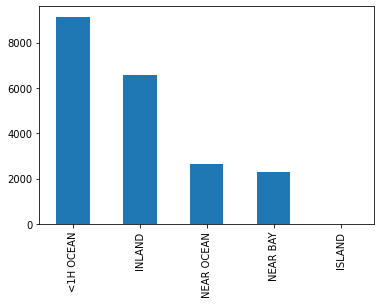

In [9]:
housing['ocean_proximity'].value_counts().plot(kind = "bar")

Horizontal bars are always better for understanding. 

<AxesSubplot:>

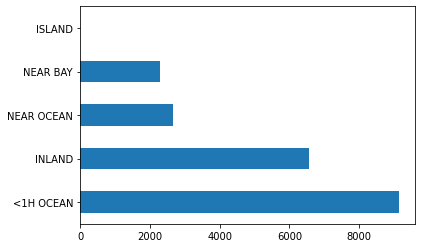

In [10]:
housing['ocean_proximity'].value_counts().plot(kind = "barh")

The `.desribe()` method shows a summary of the numerical attributes. 

In [11]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

- `median_income` has been scaled to fit between 0.5 and 15
- We will have to bring our numerical values to the same scale to make it easier for the ML model.

Another quick way to get a feel of the type of data you're working with is to plot a histogram for all the numerical attributes. The `hist()` method lets you do that in one go. 

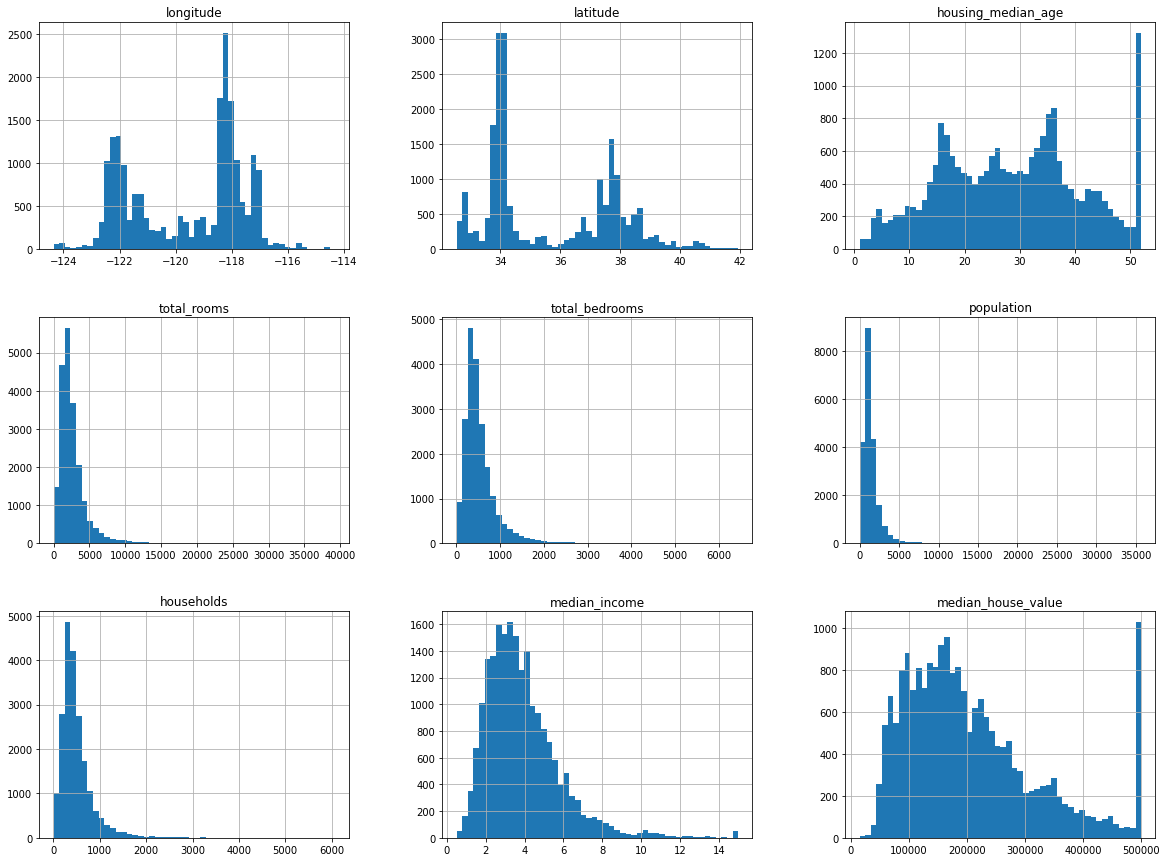

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

- `housing_median_age()` and `median_house_value()` were capped. 
- The attributes have very different scales.
- Many histograms are tail-heavy. This may make it harder for some machine learning algorithms to detect patters.

In [13]:
import numpy as np

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0.0, 1.5, 3.0, 4.5, 6., np.inf],
                              labels = [1, 2, 3, 4, 5])
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

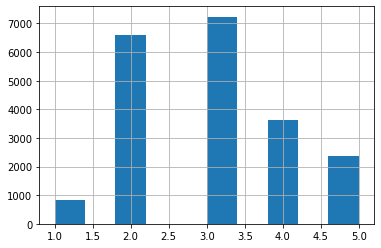

In [15]:
housing["income_cat"].hist()

# Creating training and test set

- The goal of a good machine learning model is to generalize well from the training data to any data from the problem domain. This allows us to make predictions in the future on data the model has never seen.
- Overfitting and underfitting are the two biggest causes for poor performance of machine learning algorithms.
- In statistics, a fit refers to how well you approximate a target function.
- Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.
- Underfitting refers to a model that can neither model the training data nor generalize to new data.
- That's why we reserve a portion of the data to test if our model over/under fits.

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

- `train_test_split()` basically splits your data horizontally into a training set and a test  set. 
- We pass the training set into the ML model and the model only trains on this training set.
- We then use the testing set to test the accuracy of our model

# Checking if our splits are representative of the original data

Say for example that we knew that median income was a significant predictor of median house value. We would then want the distribution of median income in our training and test sets to be roughly the same.

The reason we do this say for example we sample a training data that only had high income districts. The model would naturally think everyone in this universe was high income. So it wouldn't know how to predict the median house value for a low income district.


<AxesSubplot:>

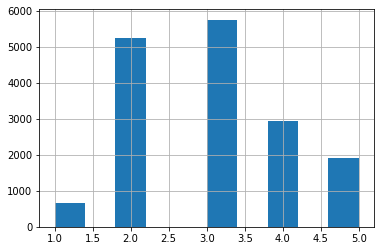

In [17]:
train_set['income_cat'].hist()

<AxesSubplot:>

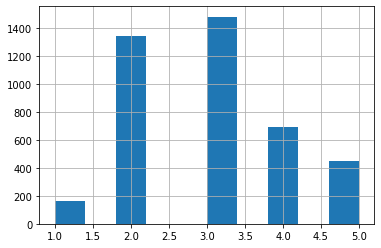

In [18]:
test_set["income_cat"].hist()

# Stratified split
The population is divided into homogenous subgroups called strata. Then right number of instances are sampled from each subgroup to make sure test set is representative of the overall population.

## So why did we choose 6 bins? 
We can see that most of the median income is clustered around 1.5 to 6, but some go far beyond 6. It is important to have sufficient number of instances in our data for each strata. Otherwise, the importance of some stratas (stratas with very few instances) may be overstated. This means you should not have too many strata and each strata should be sufficiently large.  

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

In [20]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
strat_train_set["income_cat"].value_counts()

3    5789
2    5265
4    2911
5    1890
1     657
Name: income_cat, dtype: int64

In [22]:
strat_test_set["income_cat"].value_counts()

3    1447
2    1316
4     728
5     472
1     165
Name: income_cat, dtype: int64

It's hard to judge whether each category has been equally represented based on the raw numbers because the datasets are different sizes. What we can do is check what is percentage of each category.

In [23]:
strat_train_set["income_cat"].value_counts()*100/len(strat_train_set)

3    35.059351
2    31.885901
4    17.629603
5    11.446221
1     3.978924
Name: income_cat, dtype: float64

In [24]:
strat_test_set["income_cat"].value_counts()*100/len(strat_test_set)

3    35.053295
2    31.879845
4    17.635659
5    11.434109
1     3.997093
Name: income_cat, dtype: float64

Let's drop the `income_cat` column now that we don't have any use for it. 

In [25]:
strat_train_set.drop("income_cat", axis = 1, inplace=True) # axis = 1 means columns
strat_test_set.drop("income_cat", axis = 1, inplace=True)

# Visualizing the data to gain insights
Data visualization is a very important part of any modeling process. Statistics alone can very rarely tell us what we need to know about a dataset. Visualizing data can even reveal obvious patterns that we didn't notice between datasets because all of the measures of central tendancy (mean, median, mode) are the exact same between them. 

Since there is geographical information, it is a good idea to create a scatterplot of all the districts to visualize the data.

In [26]:
housing_viz = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

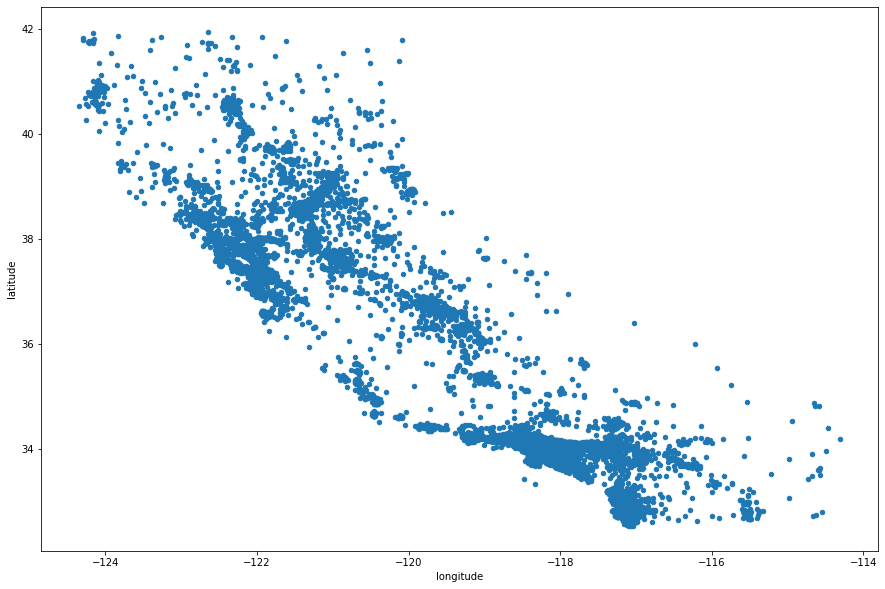

In [27]:
housing_viz.plot(kind = "scatter", x = "longitude", y = "latitude", figsize=(15, 10))

Let's make the points more transparent to make it easier to vizualize where there is a high density of data points.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

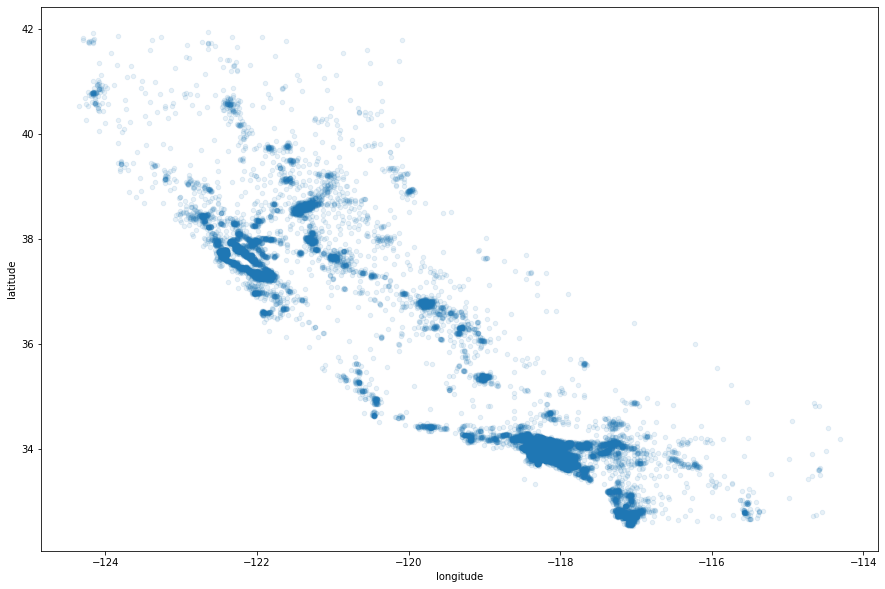

In [28]:
housing_viz.plot(kind = "scatter", x = "longitude", y = "latitude", figsize=(15, 10), alpha = 0.1)

Let's see which districts are highly populated. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

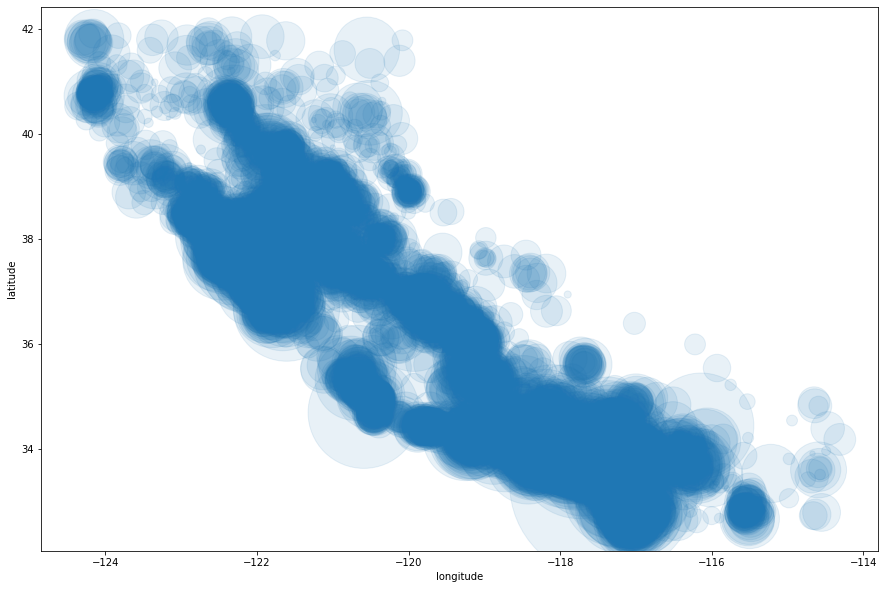

In [29]:
housing_viz.plot(kind = "scatter", 
                 x = "longitude", 
                 y = "latitude",
                 s = housing_viz["population"],
                 figsize=(15, 10), 
                 alpha = 0.1)

This makes it harder to see because the population numbers are too big. Let's scale them down a bit.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

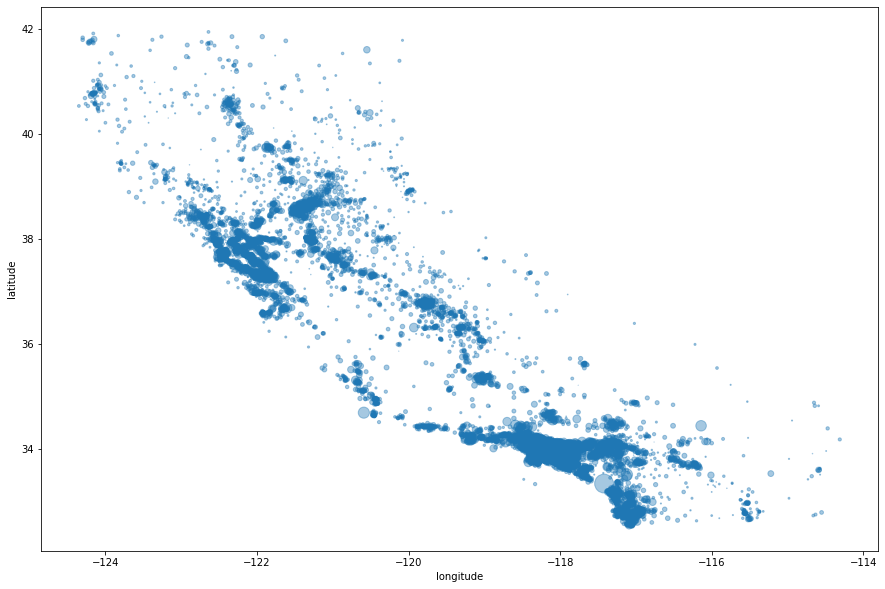

In [30]:
housing_viz.plot(kind = "scatter", 
                 x = "longitude", 
                 y = "latitude",
                 s = housing_viz["population"]/100,
                 figsize=(15, 10), 
                 alpha = 0.4)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

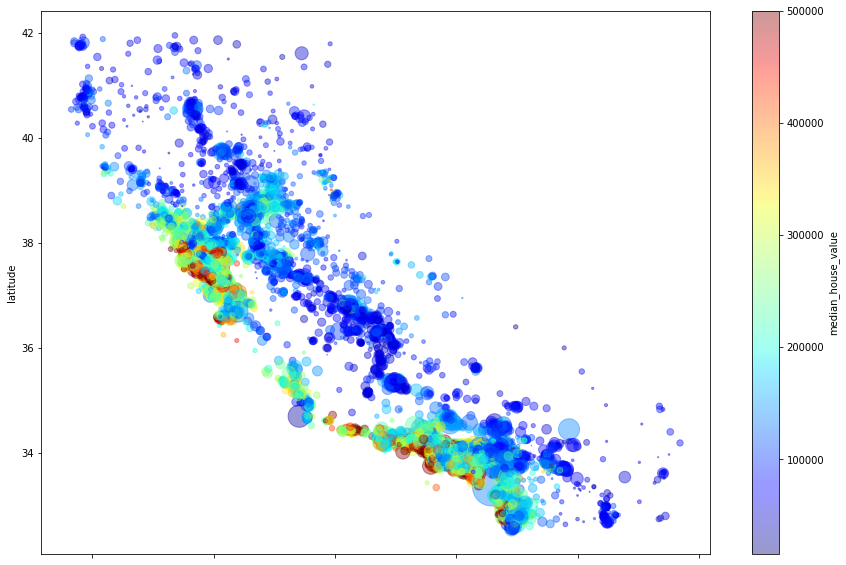

In [31]:
housing_viz.plot(kind = "scatter", 
                 x = "longitude", 
                 y = "latitude",
                 s = housing_viz["population"]/25,
                 c = "median_house_value",
                 cmap = plt.get_cmap("jet"),
                 figsize=(15, 10), 
                 alpha = 0.4)

This image tells us that housing price is very much related to location. Districts that are close to the ocean that higher median price. It also tells us that densely populated districts have a higher median house price. 

## Correlation
Correlation is the indicator of the strength of the linear relationship between two different variables. It ranges between -1 to 1. +1 means strong positive correlation and -1 means strong negative correlation. Close to 0 means no linear relationship. 

In [32]:
corr_matrix = housing_viz.corr()
corr_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924478           -0.105823     0.048909   
latitude            -0.924478  1.000000            0.005737    -0.039245   
housing_median_age  -0.105823  0.005737            1.000000    -0.364535   
total_rooms          0.048909 -0.039245           -0.364535     1.000000   
total_bedrooms       0.076686 -0.072550           -0.325101     0.929391   
population           0.108071 -0.115290           -0.298737     0.855103   
households           0.063146 -0.077765           -0.306473     0.918396   
median_income       -0.019615 -0.075146           -0.111315     0.200133   
median_house_value  -0.047466 -0.142673            0.114146     0.135140   

                    total_bedrooms  population  households  median_income  \
longitude                 0.076686    0.108071    0.063146      -0.019615   
latitude                 -0.072550   -0.115290   -0.077765      -0.075146   
housing_median_age       -0.325101   -0.298737   -0.306473      -0.111315   
total_rooms               0.929391    0.855103    0.918396       0.200133   
total_bedrooms            1.000000    0.876324    0.980167      -0.009643   
population                0.876324    1.000000    0.904639       0.002421   
households                0.980167    0.904639    1.000000       0.010869   
median_income            -0.009643    0.002421    0.010869       1.000000   
median_house_value        0.047781   -0.026882    0.064590       0.687151   

                    median_house_value  
longitude                    -0.047466  
latitude                     -0.142673  
housing_median_age            0.114146  
total_rooms                   0.135140  
total_bedrooms                0.047781  
population                   -0.026882  
households                    0.064590  
median_income                 0.687151  
median_house_value            1.000000

A correlation matrix is grid that shows the correlation coefficient of every numerical variable against every other numerical variable. It can be a good way to quickly see which variables are of particular interest for your target variable

In [33]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Let's visualize this. 

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>]],
      dtype=object)

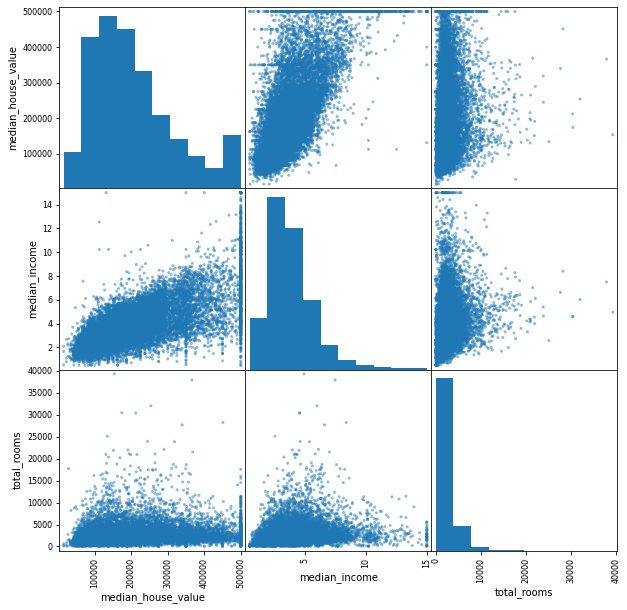

In [34]:
from pandas.plotting import scatter_matrix

features = ["median_house_value", "median_income", "total_rooms"]

scatter_matrix(housing_viz[features], figsize = (10, 10))

## Correlation cofficient only measures linear relationship

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/1920px-Correlation_examples2.svg.png)

# What have we done so far?

- We have identified a few data quirks that we may need to clean up before feeding the data to the ML algorithm
- You found interesting correlations between attributes, in particular with the target attribute.
- We noticed some attributes have a heavy tailed distribution.

# Preparing Data for Machine Learning

Data preparation is oftentimes the most time-consuming step of the modeling process. It is also one of the most important with model accuracy often contingent on the quality of data inserted. To this end, we'll be applying the following transformations on this data, not in this particular order:

-  **Feature Engineering:** Creating new features (columns) out of our raw data using domain knowledge

- **Imputation:** Inserting values where they might be missing to have a complete dataset

- **Encoding Categorical Variables:** Transforming categorical variables into some numerical variation

- **Scaling:** Applying a scaler that transforms all of our data on the same numerical scale 

First let's create another copy of the training set. Let's also seperate the predictors and labels, since we may not want to apply the same transformation to both predictors and labels.

In [47]:
housing_prep = strat_train_set.drop("median_house_value", axis = 1)
housing_prep_labels = strat_train_set["median_house_value"].copy()

# Data Cleaning

Most machine learning algorithms cannot work with missing values. So let's take care of them!We saw earlier that `total_bedrooms` had missing values. We have three options to fix this.
- Get rid of the corresponding rows (districts) -> `.dropna()`
- Get rid of the whole attribute (column) -> `.drop()`
- Set the missing values to some value (zero, mean, median etc.) -> `.fillna()`



In [49]:
rows_with_na = housing_prep[housing_prep.isnull().any(axis = 1)].head()
rows_with_na

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0             NaN   
10915    -117.87     33.73                45.0       2264.0             NaN   
19150    -122.70     38.35                14.0       2313.0             NaN   
4186     -118.23     34.13                48.0       1308.0             NaN   
16885    -122.40     37.58                26.0       3281.0             NaN   

       population  households  median_income ocean_proximity  
1606        825.0       626.0         2.9330        NEAR BAY  
10915      1970.0       499.0         3.4193       <1H OCEAN  
19150       954.0       397.0         3.7813       <1H OCEAN  
4186        835.0       294.0         4.2891       <1H OCEAN  
16885      1145.0       480.0         6.3580      NEAR OCEAN

In [50]:
rows_with_na.dropna()

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []

In [51]:
rows_with_na.drop(["total_bedrooms"], axis = 1)

longitude  latitude  housing_median_age  total_rooms  population  \
1606     -122.08     37.88                26.0       2947.0       825.0   
10915    -117.87     33.73                45.0       2264.0      1970.0   
19150    -122.70     38.35                14.0       2313.0       954.0   
4186     -118.23     34.13                48.0       1308.0       835.0   
16885    -122.40     37.58                26.0       3281.0      1145.0   

       households  median_income ocean_proximity  
1606        626.0         2.9330        NEAR BAY  
10915       499.0         3.4193       <1H OCEAN  
19150       397.0         3.7813       <1H OCEAN  
4186        294.0         4.2891       <1H OCEAN  
16885       480.0         6.3580      NEAR OCEAN

In [54]:
median = housing_prep["total_bedrooms"].median()
rows_with_na["total_bedrooms"].fillna(median, inplace = True)
rows_with_na

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0           433.0   
10915    -117.87     33.73                45.0       2264.0           433.0   
19150    -122.70     38.35                14.0       2313.0           433.0   
4186     -118.23     34.13                48.0       1308.0           433.0   
16885    -122.40     37.58                26.0       3281.0           433.0   

       population  households  median_income ocean_proximity  
1606        825.0       626.0         2.9330        NEAR BAY  
10915      1970.0       499.0         3.4193       <1H OCEAN  
19150       954.0       397.0         3.7813       <1H OCEAN  
4186        835.0       294.0         4.2891       <1H OCEAN  
16885      1145.0       480.0         6.3580      NEAR OCEAN

But instead of doing this for all the columns one by one we can use sklearn's `SimpleImputer` class to apply this strategy to all the numerical columns.

In [55]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")

Let's get only the numerical columns.

In [57]:
housing_num = housing_prep.select_dtypes(include = [np.number])
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  
12655      2237.0       706.0         2.1736  
15502      2015.0       768.0         6.3373  
2908        667.0       300.0         2.8750  
14053       898.0       483.0         2.2264  
20496      1837.0       580.0         4.4964

In [58]:
imputer.fit(housing_num) # fit the imputer to our data, basically getting the medians for all the columns
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [60]:
X = imputer.transform(housing_num)
X

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [63]:
housing_num = pd.DataFrame(X,
                          columns = housing_num.columns,
                          index = housing_num.index)
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  
12655      2237.0       706.0         2.1736  
15502      2015.0       768.0         6.3373  
2908        667.0       300.0         2.8750  
14053       898.0       483.0         2.2264  
20496      1837.0       580.0         4.4964

## Encoding categorical variables

We have seen that `ocean_proximity` is a categorical variable. Most machine learning algorithms prefer to work with numerical variables. So let's convert these to numbers. 

In [76]:
housing_cat = housing_prep[["ocean_proximity"]]
housing_cat

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
...               ...
15174       <1H OCEAN
12661          INLAND
19263       <1H OCEAN
19140       <1H OCEAN
19773          INLAND

[16512 rows x 1 columns]

In [77]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [79]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

Since `ocean_proximity` does not have an inherent ordering i.e. it's a nominal variable, it may be better to use one hot encoding. 

In [80]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse = False)

In [81]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [82]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Feature Engineering

Feature engineering is the art/science of using domain knowledge to create new features (columns) of data using raw data. This can be key to improving the performance of your Machine Learning models.

Total number of rooms in a district is not very useful if we don't know how many households there are. A more useful feature would be the number of rooms per household.

In [36]:
housing_prep["rooms_per_household"] = housing_prep["total_rooms"] / housing_prep["households"]

Similarly, total number of bedrooms is not in itself very useful. We probably want to compare it to the number of bedrooms.

In [37]:
housing_prep["bedrooms_per_room"] = housing_prep["total_bedrooms"] / housing_prep["total_rooms"]

Another interesting attribute combination to look at might be the population per household.

In [38]:
housing_prep["population_per_household"] = housing_prep["population"] / housing_prep["households"]

In [39]:
housing_merged = pd.concat([housing_prep, housing_prep_labels], axis=1)
corr_matrix = housing_merged.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

- `bedrooms_per_room` seems to be negatively correlated. Meaning housings with low bedroom/room ratio tend to be more expensive. 
- Number of rooms per household is also more informative than total number of rooms.
- This round of exploration does not have to absolutely thorough, the point is to start off on the right foot and quickly gain insights that will help you get a resonably good prototype. But this is an iterative process, once you get a prototype up and running, you can get analyze it's output to gain more insights and come back to this exploration step.

Let's get some sample rows that have null values to demonstrate these functions.

## Scaling our Data

Many machine learning algorithms don't work well with unscaled data. For example, the magnitude of values in the "total_rooms" feature is going to be substantially higher than that in the "median_income" feature (because the median_income is scaled down by 1000). Because of this we usually will need to scale our values. 

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.
Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min.

Standardization is quite different: first it subtracts the mean value (so standardized
values always have a zero mean), and then it divides by the standard deviation so that
the resulting distribution has unit variance. Unlike min-max scaling, standardization
does not bound values to a specific range, which may be a problem for some algo‐
rithms (e.g., neural networks often expect an input value ranging from 0 to 1). How‐
ever, standardization is much less affected by outliers (which we have a lot of). For example, suppose a district
had a median income equal to 100 (by mistake). Min-max scaling would then crush
all the other values from 0–15 down to 0–0.15, whereas standardization would not be
much affected


z = (x - u) / s

Where x is the value we're scaling, u is the mean of the column, and s is the standard deviation

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

housing_scaled = scaler.fit_transform(housing_num)
housing_scaled

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

# Building our data pipeline

Seperate features & labels -> Feature Engineer -> Impute missing values -> Encode categorical variables -> Scale numerical variables

In [91]:
def data_pipeline(data):
    
    # Seperate labels and features #
    labels = data["median_house_value"]
    data = data.drop("median_house_value", axis = 1)
    
    # Feature Engineering #
    features_engineered = data.copy()
    features_engineered["rooms_per_household"] = features_engineered["total_rooms"] / features_engineered["households"]
    features_engineered["bedrooms_per_room"] = features_engineered["total_bedrooms"] / features_engineered["total_rooms"]
    features_engineered["population_per_household"] = features_engineered["population"] / features_engineered["households"]
    features = list(features_engineered.columns) # Creating a list of our features for future use
    
    # Impute missing values
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")
    features_num = features_engineered.select_dtypes(include=[np.number])
    features_num_imputed = imputer.fit_transform(features_num)
    
    # Encoding categorical variables
    features_cat = features_engineered.select_dtypes(exclude=[np.number])
    
    from sklearn.preprocessing import OneHotEncoder
    cat_encoder = OneHotEncoder(sparse=False)
    features_cat_1hot = cat_encoder.fit_transform(features_cat)
    
    features = features + cat_encoder.categories_[0].tolist() # add the new 1 hot encoded features to our list
    features.remove("ocean_proximity") # We're encoding this variable, so we don't need it in our list anymore
    
    # Scaling Numerical Data #
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    features_num_imputed_scaled = scaler.fit_transform(features_num_imputed)
    
    # Join all our data together
    
    output = np.hstack([features_num_imputed_scaled, features_cat_1hot])
    
    return output, labels, features

# Select and Train a Model

## Transform our data using the "pipeline" we created 

We now need to create a clean training dataset to "train" our machine learning regressors, and a "test" set to test the accuracy of said regressors. Let's input our stratified samples into our "pipeline"

In [93]:
train_data, train_labels, features = data_pipeline(strat_train_set)

In [94]:
train_data

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [95]:
train_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

In [96]:
features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [97]:
test_data, test_labels, features = data_pipeline(strat_test_set)

## Linear Regression

In [98]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_data, train_labels)

LinearRegression()

Let's try out this model on a few instances of the training set.

In [100]:
some_data = train_data[:5]
some_labels = train_labels[:5]

In [104]:
some_preds = lin_reg.predict(some_data)
some_preds

array([ 83648.54287152, 305815.0882093 , 150013.37994426, 188096.42566946,
       241840.13952577])

In [102]:
some_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64

Let's do a quick (not thorough) check of our performance

In [105]:
some_preds - some_labels

12655    11548.542872
15502    26215.088209
2908     67313.379944
14053    75596.425669
20496     3540.139526
Name: median_house_value, dtype: float64

### RMSE on training set

In [110]:
from sklearn.metrics import mean_squared_error

lin_train_preds = lin_reg.predict(train_data)

lin_mse = mean_squared_error(train_labels, lin_train_preds)
lin_mse

4645911608.916934

In [111]:
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68160.92435491859

Okay, this is better than nothing but clearly not a great score: most districts’
median_housing_values range between 120,000 and 265,000, so a typical predic‐
tion error of $68,628 is not very satisfying. This is an example of a model underfitting
the training data. When this happens it can mean that the features do not provide
enough information to make good predictions, or that the model is not powerful
enough. The main ways to fix underfitting are to
select a more powerful model, to feed the training algorithm with better features, or
to reduce the constraints on the model. This model is not regularized, so this rules
out the last option. You could try to add more features (e.g., the log of the popula‐
tion), but first let’s try a more complex model to see how it does.

## Decision Tree Regressor

In [109]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_data, train_labels)

DecisionTreeRegressor(random_state=42)

In [112]:
tree_train_preds = tree_reg.predict(train_data)
tree_mse = mean_squared_error(train_labels, tree_train_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

No error at all? Could this model really be absolutely perfect? Of course,
it is much more likely that the model has badly overfit the data. How can you be sure?
As we saw earlier, you don’t want to touch the test set until you are ready to launch a
model you are confident about, so you need to use part of the training set for train‐
ing, and part for model validation.

## Cross validation

One way to evaluate the Decision Tree model would be to use the train_test_split
function to split the training set into a smaller training set and a validation set, then
train your models against the smaller training set and evaluate them against the vali‐
dation set. It’s a bit of work, but nothing too difficult and it would work fairly well.
A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The follow‐
ing code randomly splits the training set into 10 distinct subsets called folds, then it
trains and evaluates the Decision Tree model 10 times, picking a different fold for
evaluation every time and training on the other 9 folds. The result is an array con‐
taining the 10 evaluation scores:

![title](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [120]:
from sklearn.model_selection import cross_val_score
tree_cv_mse= cross_val_score(tree_reg, train_data, train_labels, scoring = "neg_mean_squared_error", cv = 10)

Scikit-Learn’s cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (i.e., a negative value)

In [121]:
tree_cv_rmse = np.sqrt(-tree_cv_mse)
tree_cv_rmse

array([71918.58642103, 71384.84501617, 68633.80280963, 69659.52488314,
       67941.65145966, 75921.07007104, 71837.53328882, 72468.1641427 ,
       68601.96049537, 68323.32006781])

In [122]:
tree_cv_rmse.mean()

70669.045865536

In [123]:
tree_cv_rmse.std()

2379.810209113841

It seems to perform worse than the Linear Regression model! Notice that cross-validation allows
you to get not only an estimate of the performance of your model, but also a measure
of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a
score of approximately 71,407, generally ±2,439.

Let's do the same for our linear regression model.

In [133]:
lin_cv_mse = cross_val_score(lin_reg, train_data, train_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_cv_rmse = np.sqrt(-lin_cv_mse)

In [134]:
lin_cv_rmse.mean()

68439.72141026422

In [135]:
lin_cv_rmse.std()

2408.8928462974695

## Random Forest Regressor
Random Forests work by training many Decision Trees on random subsets of
the features, then averaging out their predictions. Building a model on top of many
other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further

In [137]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
forest_reg.fit(train_data, train_labels)

RandomForestRegressor(random_state=42)

In [138]:
forest_cv_mse = cross_val_score(forest_reg, train_data, train_labels, scoring = "neg_mean_squared_error", cv = 10)

In [139]:
forest_cv_rmse = np.sqrt(-forest_cv_mse)

In [140]:
forest_cv_rmse.mean()

50339.50540453655

In [141]:
forest_cv_rmse.std()

2206.1714766286996

# Fine tuning our model

After you pick a model or set of models that are promising, you'll need to fine-tune the hyperparameters in order to find the best ones to use for your model. A model hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data. We can use something called Grid Search in order to accomplish this. 

## Grid search

In [142]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [143]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [155]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65119.22597571509 {'max_features': 2, 'n_estimators': 3}
55223.5947809774 {'max_features': 2, 'n_estimators': 10}
52786.159328222646 {'max_features': 2, 'n_estimators': 30}
60681.200130349374 {'max_features': 4, 'n_estimators': 3}
52490.03868445132 {'max_features': 4, 'n_estimators': 10}
50472.09736091612 {'max_features': 4, 'n_estimators': 30}
58333.75312490932 {'max_features': 6, 'n_estimators': 3}
51766.98839356613 {'max_features': 6, 'n_estimators': 10}
49882.96011935094 {'max_features': 6, 'n_estimators': 30}
59288.94215890149 {'max_features': 8, 'n_estimators': 3}
52040.865576692486 {'max_features': 8, 'n_estimators': 10}
49985.97352309603 {'max_features': 8, 'n_estimators': 30}
63210.50747680449 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54510.12433444709 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58152.56594870564 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51810.53293480496 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

## Randomized Search

Randomized search allows you to more easily find the hyperparameters that we're interested in because instead of searching through all possible combinations, it randomly picks a couple and tries those out. 

In [145]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_data, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1be9686040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1be967a490>},
                   random_state=42, scoring='neg_mean_squared_error')

In [146]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

## Feature importance

In [150]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.69973806e-02, 7.00351211e-02, 4.19508377e-02, 1.72928616e-02,
       1.72956635e-02, 1.78824437e-02, 1.64855146e-02, 3.26982327e-01,
       4.97468264e-02, 8.47983613e-02, 1.04610459e-01, 1.60147674e-02,
       1.51555966e-01, 7.55747095e-05, 3.25555065e-03, 5.02034486e-03])

In [152]:
feature_importances_list = list(zip(features, feature_importances))
feature_importances_list

[('longitude', 0.07699738055141943),
 ('latitude', 0.07003512112918531),
 ('housing_median_age', 0.041950837711577045),
 ('total_rooms', 0.017292861637860507),
 ('total_bedrooms', 0.017295663459248437),
 ('population', 0.01788244367196627),
 ('households', 0.01648551458288839),
 ('median_income', 0.326982327162615),
 ('rooms_per_household', 0.049746826352699065),
 ('bedrooms_per_room', 0.08479836130519176),
 ('population_per_household', 0.10461045889757281),
 ('<1H OCEAN', 0.01601476737636536),
 ('INLAND', 0.1515559659408615),
 ('ISLAND', 7.55747095254322e-05),
 ('NEAR BAY', 0.00325555065072949),
 ('NEAR OCEAN', 0.005020344860294099)]

<BarContainer object of 16 artists>

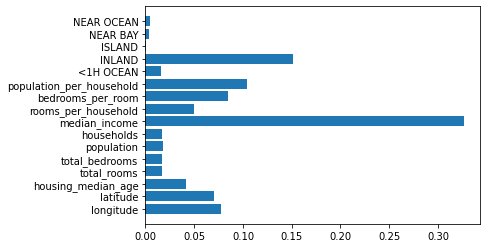

In [153]:
plt.barh(y=features, width=feature_importances.tolist(), )

# Final Model

In [156]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(test_data)

In [157]:
final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

64105.377424193844

# Saving your model for production

In [158]:
import pickle

In [165]:
MODEL_PATH = os.path.join(PWD, "final_model.pkl",)
with open(MODEL_PATH, 'wb') as handle:
    pickle.dump(final_model, handle, pickle.HIGHEST_PROTOCOL)

# Loading model

In [166]:
with open(MODEL_PATH, 'rb') as handle:
    loaded_model = pickle.load(handle)  

In [167]:
loaded_model

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

# Next steps

- Deploy your model
- Collect fresh data regularly. 
- Write a script to retrain and fine-tune your model in regular intervals
- Write a script that will evaluate both the old model and the new model based on the updated test set, and deploy the new model if performance has not decreased
- If performance has decreased we have to go back to discovery and figure out why.